# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [2]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

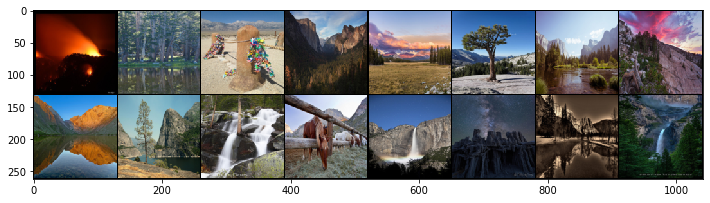

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

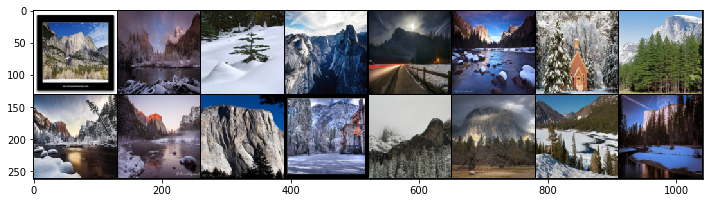

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(1.)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(1.)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        #128x128
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        #64x64
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        #32x32
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        #16x16
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        #8x8
        
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1,batch_norm=False)
        

    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        x = self.conv5(x)
        
        return x

In [11]:
test = Discriminator()
for x, _ in dataloader_X:
    print(x.shape)
    out = test(x)
    print(out.shape)
    break
#img_test = transforms

torch.Size([16, 3, 128, 128])
torch.Size([16, 1, 7, 7])


## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [12]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv1 = conv(conv_dim, conv_dim, 3, stride=1)
        self.conv2 = conv(conv_dim, conv_dim, 3, stride=1)
        
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        return out + x
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [13]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [14]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.conv1 = conv(3, conv_dim, 4, stride=2)
        self.conv2 = conv(conv_dim, conv_dim*2, 4, stride=2)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4, stride=2)
        
        # 2. Define the resnet part of the generator
        self.res1 = ResidualBlock(conv_dim*4)
        self.res2 = ResidualBlock(conv_dim*4)
        self.res3 = ResidualBlock(conv_dim*4)
        
        # 3. Define the decoder part of the generator
        self.tconv1 = deconv(conv_dim*4, conv_dim*2, 4, stride=2)
        self.tconv2 = deconv(conv_dim*2, conv_dim, 4, stride=2)
        self.tconv3 = deconv(conv_dim, 3, 4, stride=2, batch_norm=False)
        

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.res1(x))
        x = F.relu(self.res2(x))
        x = F.relu(self.res3(x))
        
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        out = self.tconv3(x)
        
        out = torch.tanh(out)

        return out

In [15]:
test = CycleGenerator()
for x, _ in dataloader_X:
    print(x.shape)
    out = test(x)
    print(out.shape)
    break
#img_test = transforms

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [16]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(g_conv_dim, n_res_blocks)
    G_YtoX = CycleGenerator(g_conv_dim, n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [39]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [40]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res1): ResidualBlock(
    (conv1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): 

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [41]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)
    

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean((D_out-0)**2)
    

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight=10):
    # calculate reconstruction loss 
    # return weighted loss
    return lambda_weight*torch.mean(torch.abs(reconstructed_im-real_im))
    


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [42]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr=0.0002
beta1=0.5
beta2= 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [43]:
# import save code
from helpers import save_samples, checkpoint

In [44]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        d_x_optimizer.zero_grad()
        d_x_out = D_X(images_X)
        # 1. Compute the discriminator losses on real images
        
        d_x_real_loss = real_mse_loss(d_x_out)
        # 2. Generate fake images that look like domain X based on real images in domain Y
        images_YtoX = G_YtoX(images_Y)
        # 3. Compute the fake loss for D_X
        d_x_fake_loss = fake_mse_loss(D_X(images_YtoX))
        # 4. Compute the total loss and perform backprop
        d_x_loss = d_x_real_loss + d_x_fake_loss
        
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        d_y_optimizer.zero_grad()
        d_y_out = D_Y(images_Y)
        # 1. Compute the discriminator losses on real images
        
        d_y_real_loss = real_mse_loss(d_y_out)
        # 2. Generate fake images that look like domain X based on real images in domain Y
        images_XtoY = G_XtoY(images_X)
        # 3. Compute the fake loss for D_X
        d_y_fake_loss = fake_mse_loss(D_Y(images_XtoY))
        # 4. Compute the total loss and perform backprop
        d_y_loss = d_y_real_loss + d_y_fake_loss
        
        d_y_loss.backward()
        d_y_optimizer.step()
        


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================
        g_optimizer.zero_grad()
        ##    First: generate fake X images and reconstructed Y images    ##
        # 1. Generate fake images that look like domain X based on real images in domain Y
        images_YtoX = G_YtoX(images_Y)
        # 2. Compute the generator loss based on domain X
        g_ytox_real_loss = real_mse_loss(D_X(images_YtoX))
        # 3. Create a reconstructed y
        images_Y_reconstructed = G_XtoY(images_YtoX)
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        g_x_cycle_loss = cycle_consistency_loss(images_Y, images_Y_reconstructed)

        ##    Second: generate fake Y images and reconstructed X images    ##
        # 1. Generate fake images that look like domain X based on real images in domain Y
        images_XtoY = G_XtoY(images_X)
        # 2. Compute the generator loss based on domain X
        g_xtoy_real_loss = real_mse_loss(D_Y(images_XtoY))
        # 3. Create a reconstructed y
        images_X_reconstructed = G_YtoX(images_XtoY)
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        g_y_cycle_loss = cycle_consistency_loss(images_X, images_X_reconstructed)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_ytox_real_loss + g_x_cycle_loss + g_xtoy_real_loss + g_y_cycle_loss
        g_total_loss.backward()
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
        checkpoint_every=1000
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            print("Saving models...")
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [45]:
n_epochs = 4000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.3479 | d_Y_loss: 0.2985 | g_total_loss: 9.5538
Epoch [   20/ 4000] | d_X_loss: 0.2477 | d_Y_loss: 0.3572 | g_total_loss: 7.8285
Epoch [   30/ 4000] | d_X_loss: 0.4773 | d_Y_loss: 0.5554 | g_total_loss: 7.6564
Epoch [   40/ 4000] | d_X_loss: 0.2787 | d_Y_loss: 0.3641 | g_total_loss: 6.6180
Epoch [   50/ 4000] | d_X_loss: 0.3223 | d_Y_loss: 0.3299 | g_total_loss: 5.7776
Epoch [   60/ 4000] | d_X_loss: 0.3626 | d_Y_loss: 0.4781 | g_total_loss: 5.4725
Epoch [   70/ 4000] | d_X_loss: 0.5673 | d_Y_loss: 0.4445 | g_total_loss: 5.4824
Epoch [   80/ 4000] | d_X_loss: 0.3433 | d_Y_loss: 0.3023 | g_total_loss: 5.2474
Epoch [   90/ 4000] | d_X_loss: 0.3537 | d_Y_loss: 0.4543 | g_total_loss: 4.7406


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 4000] | d_X_loss: 0.4115 | d_Y_loss: 0.4691 | g_total_loss: 4.2593


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.4248 | d_Y_loss: 0.4737 | g_total_loss: 4.1485
Epoch [  120/ 4000] | d_X_loss: 0.4136 | d_Y_loss: 0.3887 | g_total_loss: 4.6504
Epoch [  130/ 4000] | d_X_loss: 0.4540 | d_Y_loss: 0.4806 | g_total_loss: 4.7905
Epoch [  140/ 4000] | d_X_loss: 0.4903 | d_Y_loss: 0.4614 | g_total_loss: 4.4106
Epoch [  150/ 4000] | d_X_loss: 0.4147 | d_Y_loss: 0.3462 | g_total_loss: 4.2489
Epoch [  160/ 4000] | d_X_loss: 0.3117 | d_Y_loss: 0.4552 | g_total_loss: 5.0657
Epoch [  170/ 4000] | d_X_loss: 0.4423 | d_Y_loss: 0.5070 | g_total_loss: 4.1988
Epoch [  180/ 4000] | d_X_loss: 0.2605 | d_Y_loss: 0.4372 | g_total_loss: 5.1954
Epoch [  190/ 4000] | d_X_loss: 0.3575 | d_Y_loss: 0.3756 | g_total_loss: 3.8426


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 4000] | d_X_loss: 0.4281 | d_Y_loss: 0.3881 | g_total_loss: 5.1933


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.3924 | d_Y_loss: 0.4897 | g_total_loss: 5.3412
Epoch [  220/ 4000] | d_X_loss: 0.4460 | d_Y_loss: 0.5043 | g_total_loss: 5.1548
Epoch [  230/ 4000] | d_X_loss: 0.5624 | d_Y_loss: 0.3584 | g_total_loss: 4.7472
Epoch [  240/ 4000] | d_X_loss: 0.4535 | d_Y_loss: 0.4059 | g_total_loss: 4.2786
Epoch [  250/ 4000] | d_X_loss: 0.3889 | d_Y_loss: 0.3487 | g_total_loss: 4.9089
Epoch [  260/ 4000] | d_X_loss: 0.3191 | d_Y_loss: 0.4116 | g_total_loss: 4.7436
Epoch [  270/ 4000] | d_X_loss: 0.5186 | d_Y_loss: 0.4805 | g_total_loss: 3.6114
Epoch [  280/ 4000] | d_X_loss: 0.2975 | d_Y_loss: 0.3824 | g_total_loss: 4.3453
Epoch [  290/ 4000] | d_X_loss: 0.7906 | d_Y_loss: 0.5322 | g_total_loss: 4.5374


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/ 4000] | d_X_loss: 0.5511 | d_Y_loss: 0.4104 | g_total_loss: 3.6794


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.3712 | d_Y_loss: 0.1622 | g_total_loss: 5.2975
Epoch [  320/ 4000] | d_X_loss: 0.3459 | d_Y_loss: 0.4733 | g_total_loss: 4.3367
Epoch [  330/ 4000] | d_X_loss: 0.3019 | d_Y_loss: 0.3265 | g_total_loss: 4.4770
Epoch [  340/ 4000] | d_X_loss: 0.3391 | d_Y_loss: 0.1985 | g_total_loss: 4.4710
Epoch [  350/ 4000] | d_X_loss: 0.4327 | d_Y_loss: 0.3021 | g_total_loss: 4.3967
Epoch [  360/ 4000] | d_X_loss: 0.4414 | d_Y_loss: 0.2619 | g_total_loss: 4.3248
Epoch [  370/ 4000] | d_X_loss: 0.3666 | d_Y_loss: 0.4892 | g_total_loss: 4.3285
Epoch [  380/ 4000] | d_X_loss: 0.4816 | d_Y_loss: 0.3216 | g_total_loss: 4.6673
Epoch [  390/ 4000] | d_X_loss: 0.3770 | d_Y_loss: 0.5990 | g_total_loss: 3.4090


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/ 4000] | d_X_loss: 0.8888 | d_Y_loss: 0.3531 | g_total_loss: 4.7142


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.3600 | d_Y_loss: 0.7776 | g_total_loss: 4.6483
Epoch [  420/ 4000] | d_X_loss: 0.3023 | d_Y_loss: 0.3116 | g_total_loss: 4.6938
Epoch [  430/ 4000] | d_X_loss: 1.0703 | d_Y_loss: 0.3578 | g_total_loss: 4.0954
Epoch [  440/ 4000] | d_X_loss: 0.3747 | d_Y_loss: 0.3543 | g_total_loss: 4.1953
Epoch [  450/ 4000] | d_X_loss: 0.2912 | d_Y_loss: 0.3455 | g_total_loss: 4.5366
Epoch [  460/ 4000] | d_X_loss: 0.4276 | d_Y_loss: 0.4781 | g_total_loss: 3.5438
Epoch [  470/ 4000] | d_X_loss: 0.3253 | d_Y_loss: 0.3250 | g_total_loss: 4.4922
Epoch [  480/ 4000] | d_X_loss: 0.3471 | d_Y_loss: 0.0961 | g_total_loss: 4.5769
Epoch [  490/ 4000] | d_X_loss: 0.2354 | d_Y_loss: 0.4595 | g_total_loss: 4.0886


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/ 4000] | d_X_loss: 0.3714 | d_Y_loss: 0.3159 | g_total_loss: 4.9022


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.3934 | d_Y_loss: 0.2583 | g_total_loss: 4.0400
Epoch [  520/ 4000] | d_X_loss: 0.1452 | d_Y_loss: 0.2673 | g_total_loss: 4.2458
Epoch [  530/ 4000] | d_X_loss: 0.3951 | d_Y_loss: 0.3871 | g_total_loss: 4.1849
Epoch [  540/ 4000] | d_X_loss: 0.3031 | d_Y_loss: 0.3578 | g_total_loss: 4.1400
Epoch [  550/ 4000] | d_X_loss: 0.3770 | d_Y_loss: 0.3758 | g_total_loss: 4.4061
Epoch [  560/ 4000] | d_X_loss: 0.2239 | d_Y_loss: 0.2866 | g_total_loss: 4.7743
Epoch [  570/ 4000] | d_X_loss: 0.3498 | d_Y_loss: 0.3295 | g_total_loss: 4.3401
Epoch [  580/ 4000] | d_X_loss: 0.2772 | d_Y_loss: 0.2933 | g_total_loss: 5.0616
Epoch [  590/ 4000] | d_X_loss: 1.0618 | d_Y_loss: 0.3340 | g_total_loss: 6.4490


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/ 4000] | d_X_loss: 0.4384 | d_Y_loss: 0.3556 | g_total_loss: 4.1821


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.2359 | d_Y_loss: 0.3799 | g_total_loss: 4.8175
Epoch [  620/ 4000] | d_X_loss: 0.4239 | d_Y_loss: 0.4102 | g_total_loss: 4.1185
Epoch [  630/ 4000] | d_X_loss: 0.3472 | d_Y_loss: 0.3989 | g_total_loss: 4.0840
Epoch [  640/ 4000] | d_X_loss: 0.3677 | d_Y_loss: 0.3661 | g_total_loss: 4.8237
Epoch [  650/ 4000] | d_X_loss: 0.3765 | d_Y_loss: 0.4013 | g_total_loss: 4.4253
Epoch [  660/ 4000] | d_X_loss: 0.5132 | d_Y_loss: 0.5624 | g_total_loss: 5.1091
Epoch [  670/ 4000] | d_X_loss: 0.1856 | d_Y_loss: 0.2838 | g_total_loss: 4.1566
Epoch [  680/ 4000] | d_X_loss: 0.3285 | d_Y_loss: 0.3164 | g_total_loss: 4.9332
Epoch [  690/ 4000] | d_X_loss: 0.3874 | d_Y_loss: 0.3285 | g_total_loss: 3.7607


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/ 4000] | d_X_loss: 0.5027 | d_Y_loss: 0.2710 | g_total_loss: 4.1526


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.3187 | d_Y_loss: 0.3227 | g_total_loss: 4.2318
Epoch [  720/ 4000] | d_X_loss: 0.2484 | d_Y_loss: 0.3604 | g_total_loss: 3.9059
Epoch [  730/ 4000] | d_X_loss: 0.2904 | d_Y_loss: 0.3727 | g_total_loss: 4.1038
Epoch [  740/ 4000] | d_X_loss: 0.4670 | d_Y_loss: 0.2858 | g_total_loss: 4.0990
Epoch [  750/ 4000] | d_X_loss: 0.4494 | d_Y_loss: 0.1982 | g_total_loss: 4.9786
Epoch [  760/ 4000] | d_X_loss: 0.3348 | d_Y_loss: 0.3241 | g_total_loss: 4.0415
Epoch [  770/ 4000] | d_X_loss: 0.3347 | d_Y_loss: 0.2688 | g_total_loss: 4.2258
Epoch [  780/ 4000] | d_X_loss: 0.4257 | d_Y_loss: 0.3074 | g_total_loss: 4.1580
Epoch [  790/ 4000] | d_X_loss: 0.3362 | d_Y_loss: 0.3570 | g_total_loss: 4.5066


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/ 4000] | d_X_loss: 0.2896 | d_Y_loss: 0.4334 | g_total_loss: 4.1927


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.3451 | d_Y_loss: 0.2566 | g_total_loss: 4.2599
Epoch [  820/ 4000] | d_X_loss: 0.3086 | d_Y_loss: 0.2888 | g_total_loss: 4.5755
Epoch [  830/ 4000] | d_X_loss: 0.3973 | d_Y_loss: 0.2270 | g_total_loss: 4.9796
Epoch [  840/ 4000] | d_X_loss: 0.3260 | d_Y_loss: 0.5537 | g_total_loss: 4.9198
Epoch [  850/ 4000] | d_X_loss: 0.3092 | d_Y_loss: 0.3772 | g_total_loss: 3.7572
Epoch [  860/ 4000] | d_X_loss: 0.1250 | d_Y_loss: 0.2965 | g_total_loss: 5.1739
Epoch [  870/ 4000] | d_X_loss: 0.2962 | d_Y_loss: 0.3448 | g_total_loss: 4.6522
Epoch [  880/ 4000] | d_X_loss: 0.2124 | d_Y_loss: 0.3049 | g_total_loss: 3.9038
Epoch [  890/ 4000] | d_X_loss: 0.3659 | d_Y_loss: 0.2762 | g_total_loss: 4.5083


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 4000] | d_X_loss: 0.3098 | d_Y_loss: 0.1933 | g_total_loss: 4.4402


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.2341 | d_Y_loss: 0.2868 | g_total_loss: 4.3740
Epoch [  920/ 4000] | d_X_loss: 0.0812 | d_Y_loss: 0.1446 | g_total_loss: 5.1132
Epoch [  930/ 4000] | d_X_loss: 0.4101 | d_Y_loss: 0.1575 | g_total_loss: 4.7823
Epoch [  940/ 4000] | d_X_loss: 0.3473 | d_Y_loss: 0.2043 | g_total_loss: 5.5437
Epoch [  950/ 4000] | d_X_loss: 0.2051 | d_Y_loss: 0.3738 | g_total_loss: 4.8076
Epoch [  960/ 4000] | d_X_loss: 0.2902 | d_Y_loss: 0.3283 | g_total_loss: 5.6367
Epoch [  970/ 4000] | d_X_loss: 0.3254 | d_Y_loss: 0.5956 | g_total_loss: 4.8023
Epoch [  980/ 4000] | d_X_loss: 0.2604 | d_Y_loss: 0.3917 | g_total_loss: 4.1381
Epoch [  990/ 4000] | d_X_loss: 0.3587 | d_Y_loss: 0.1272 | g_total_loss: 4.3122


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 4000] | d_X_loss: 0.3277 | d_Y_loss: 0.2775 | g_total_loss: 4.0393


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Saving models...
Epoch [ 1010/ 4000] | d_X_loss: 0.3248 | d_Y_loss: 0.3829 | g_total_loss: 4.2315
Epoch [ 1020/ 4000] | d_X_loss: 0.2260 | d_Y_loss: 0.2954 | g_total_loss: 5.1014
Epoch [ 1030/ 4000] | d_X_loss: 0.2351 | d_Y_loss: 0.1963 | g_total_loss: 4.7176
Epoch [ 1040/ 4000] | d_X_loss: 0.3379 | d_Y_loss: 0.3469 | g_total_loss: 5.2078
Epoch [ 1050/ 4000] | d_X_loss: 0.3842 | d_Y_loss: 0.4022 | g_total_loss: 4.3631
Epoch [ 1060/ 4000] | d_X_loss: 0.3987 | d_Y_loss: 0.1812 | g_total_loss: 3.4747
Epoch [ 1070/ 4000] | d_X_loss: 0.2311 | d_Y_loss: 0.2264 | g_total_loss: 3.9203
Epoch [ 1080/ 4000] | d_X_loss: 0.1659 | d_Y_loss: 1.2324 | g_total_loss: 8.3620
Epoch [ 1090/ 4000] | d_X_loss: 0.2602 | d_Y_loss: 0.3765 | g_total_loss: 3.6027


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/ 4000] | d_X_loss: 0.3969 | d_Y_loss: 0.2817 | g_total_loss: 3.6102


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.4460 | d_Y_loss: 0.3144 | g_total_loss: 5.3476
Epoch [ 1120/ 4000] | d_X_loss: 0.6125 | d_Y_loss: 0.2594 | g_total_loss: 3.2889
Epoch [ 1130/ 4000] | d_X_loss: 0.2047 | d_Y_loss: 0.2900 | g_total_loss: 4.1426
Epoch [ 1140/ 4000] | d_X_loss: 0.4893 | d_Y_loss: 0.4179 | g_total_loss: 3.9763
Epoch [ 1150/ 4000] | d_X_loss: 0.3835 | d_Y_loss: 0.3468 | g_total_loss: 4.6975
Epoch [ 1160/ 4000] | d_X_loss: 0.4071 | d_Y_loss: 0.4730 | g_total_loss: 4.1409
Epoch [ 1170/ 4000] | d_X_loss: 0.2292 | d_Y_loss: 0.2251 | g_total_loss: 4.0972
Epoch [ 1180/ 4000] | d_X_loss: 0.5371 | d_Y_loss: 0.2539 | g_total_loss: 3.5308
Epoch [ 1190/ 4000] | d_X_loss: 0.3330 | d_Y_loss: 0.3269 | g_total_loss: 4.4609


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/ 4000] | d_X_loss: 0.3491 | d_Y_loss: 0.3517 | g_total_loss: 4.7199


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.1287 | d_Y_loss: 0.3153 | g_total_loss: 4.6647
Epoch [ 1220/ 4000] | d_X_loss: 0.1504 | d_Y_loss: 0.4126 | g_total_loss: 3.6166
Epoch [ 1230/ 4000] | d_X_loss: 0.8414 | d_Y_loss: 0.2155 | g_total_loss: 5.0447
Epoch [ 1240/ 4000] | d_X_loss: 0.2164 | d_Y_loss: 0.1746 | g_total_loss: 4.2845
Epoch [ 1250/ 4000] | d_X_loss: 0.2199 | d_Y_loss: 0.2383 | g_total_loss: 3.8257
Epoch [ 1260/ 4000] | d_X_loss: 0.3314 | d_Y_loss: 0.5878 | g_total_loss: 5.0209
Epoch [ 1270/ 4000] | d_X_loss: 0.1627 | d_Y_loss: 0.1737 | g_total_loss: 4.4755
Epoch [ 1280/ 4000] | d_X_loss: 0.6493 | d_Y_loss: 0.2290 | g_total_loss: 6.5988
Epoch [ 1290/ 4000] | d_X_loss: 0.3026 | d_Y_loss: 0.3789 | g_total_loss: 4.1636


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1300/ 4000] | d_X_loss: 0.3119 | d_Y_loss: 0.3097 | g_total_loss: 4.2803


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.2922 | d_Y_loss: 0.2200 | g_total_loss: 3.9863
Epoch [ 1320/ 4000] | d_X_loss: 0.2511 | d_Y_loss: 0.2225 | g_total_loss: 4.3311
Epoch [ 1330/ 4000] | d_X_loss: 0.4706 | d_Y_loss: 0.2208 | g_total_loss: 4.4603
Epoch [ 1340/ 4000] | d_X_loss: 0.2513 | d_Y_loss: 0.3199 | g_total_loss: 3.6841
Epoch [ 1350/ 4000] | d_X_loss: 0.2397 | d_Y_loss: 0.2684 | g_total_loss: 3.8673
Epoch [ 1360/ 4000] | d_X_loss: 0.3162 | d_Y_loss: 0.3231 | g_total_loss: 3.5078
Epoch [ 1370/ 4000] | d_X_loss: 0.2240 | d_Y_loss: 0.2194 | g_total_loss: 4.4191
Epoch [ 1380/ 4000] | d_X_loss: 0.2208 | d_Y_loss: 0.1967 | g_total_loss: 3.7230
Epoch [ 1390/ 4000] | d_X_loss: 0.2896 | d_Y_loss: 0.3114 | g_total_loss: 3.4742


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/ 4000] | d_X_loss: 0.2518 | d_Y_loss: 0.3640 | g_total_loss: 5.0451


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.3599 | d_Y_loss: 0.5788 | g_total_loss: 3.7990
Epoch [ 1420/ 4000] | d_X_loss: 0.4504 | d_Y_loss: 0.3716 | g_total_loss: 3.3998
Epoch [ 1430/ 4000] | d_X_loss: 0.2215 | d_Y_loss: 0.1805 | g_total_loss: 4.3489
Epoch [ 1440/ 4000] | d_X_loss: 0.2192 | d_Y_loss: 0.2792 | g_total_loss: 4.1868
Epoch [ 1450/ 4000] | d_X_loss: 0.0683 | d_Y_loss: 0.2433 | g_total_loss: 4.2577
Epoch [ 1460/ 4000] | d_X_loss: 0.2400 | d_Y_loss: 0.2285 | g_total_loss: 4.7547
Epoch [ 1470/ 4000] | d_X_loss: 0.2613 | d_Y_loss: 0.4120 | g_total_loss: 5.8584
Epoch [ 1480/ 4000] | d_X_loss: 0.1372 | d_Y_loss: 0.2600 | g_total_loss: 4.9488
Epoch [ 1490/ 4000] | d_X_loss: 0.2919 | d_Y_loss: 0.1400 | g_total_loss: 5.1713


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1500/ 4000] | d_X_loss: 0.2105 | d_Y_loss: 0.1768 | g_total_loss: 4.5570


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.3027 | d_Y_loss: 0.2218 | g_total_loss: 3.9897
Epoch [ 1520/ 4000] | d_X_loss: 0.1078 | d_Y_loss: 0.2285 | g_total_loss: 4.6802
Epoch [ 1530/ 4000] | d_X_loss: 0.2175 | d_Y_loss: 0.3760 | g_total_loss: 3.7177
Epoch [ 1540/ 4000] | d_X_loss: 0.1478 | d_Y_loss: 0.3215 | g_total_loss: 4.5554
Epoch [ 1550/ 4000] | d_X_loss: 0.1341 | d_Y_loss: 0.3018 | g_total_loss: 4.5728
Epoch [ 1560/ 4000] | d_X_loss: 0.1799 | d_Y_loss: 0.2638 | g_total_loss: 3.9880
Epoch [ 1570/ 4000] | d_X_loss: 0.1676 | d_Y_loss: 0.1800 | g_total_loss: 3.9134
Epoch [ 1580/ 4000] | d_X_loss: 0.2637 | d_Y_loss: 0.2540 | g_total_loss: 4.1435
Epoch [ 1590/ 4000] | d_X_loss: 0.2059 | d_Y_loss: 0.1648 | g_total_loss: 4.2304


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1600/ 4000] | d_X_loss: 0.2277 | d_Y_loss: 0.1256 | g_total_loss: 5.4792


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.1308 | d_Y_loss: 0.2356 | g_total_loss: 3.6766
Epoch [ 1620/ 4000] | d_X_loss: 0.2755 | d_Y_loss: 0.2896 | g_total_loss: 3.5378
Epoch [ 1630/ 4000] | d_X_loss: 0.1775 | d_Y_loss: 0.2569 | g_total_loss: 3.9814
Epoch [ 1640/ 4000] | d_X_loss: 0.1916 | d_Y_loss: 0.3861 | g_total_loss: 3.5614
Epoch [ 1650/ 4000] | d_X_loss: 0.1194 | d_Y_loss: 0.2214 | g_total_loss: 4.8059
Epoch [ 1660/ 4000] | d_X_loss: 0.2604 | d_Y_loss: 0.3070 | g_total_loss: 4.0740
Epoch [ 1670/ 4000] | d_X_loss: 0.3858 | d_Y_loss: 0.1879 | g_total_loss: 3.6542
Epoch [ 1680/ 4000] | d_X_loss: 0.1185 | d_Y_loss: 0.1913 | g_total_loss: 4.0798
Epoch [ 1690/ 4000] | d_X_loss: 0.2592 | d_Y_loss: 0.4037 | g_total_loss: 3.7449


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1700/ 4000] | d_X_loss: 0.2704 | d_Y_loss: 0.2671 | g_total_loss: 3.6218


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.1833 | d_Y_loss: 0.9049 | g_total_loss: 4.9440
Epoch [ 1720/ 4000] | d_X_loss: 0.3547 | d_Y_loss: 0.1861 | g_total_loss: 3.8697
Epoch [ 1730/ 4000] | d_X_loss: 0.1296 | d_Y_loss: 0.2110 | g_total_loss: 4.2474
Epoch [ 1740/ 4000] | d_X_loss: 0.1500 | d_Y_loss: 0.1970 | g_total_loss: 5.1161
Epoch [ 1750/ 4000] | d_X_loss: 0.1646 | d_Y_loss: 0.2840 | g_total_loss: 4.4359
Epoch [ 1760/ 4000] | d_X_loss: 0.2599 | d_Y_loss: 0.4121 | g_total_loss: 3.2977
Epoch [ 1770/ 4000] | d_X_loss: 0.0765 | d_Y_loss: 0.4010 | g_total_loss: 4.3248
Epoch [ 1780/ 4000] | d_X_loss: 0.1435 | d_Y_loss: 0.1604 | g_total_loss: 3.5768
Epoch [ 1790/ 4000] | d_X_loss: 0.1488 | d_Y_loss: 0.1685 | g_total_loss: 3.9038


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/ 4000] | d_X_loss: 0.2657 | d_Y_loss: 0.5307 | g_total_loss: 3.4279


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.1209 | d_Y_loss: 0.2141 | g_total_loss: 4.0739
Epoch [ 1820/ 4000] | d_X_loss: 0.1502 | d_Y_loss: 0.1385 | g_total_loss: 5.1710
Epoch [ 1830/ 4000] | d_X_loss: 0.0626 | d_Y_loss: 0.1540 | g_total_loss: 4.3625
Epoch [ 1840/ 4000] | d_X_loss: 0.0879 | d_Y_loss: 0.3373 | g_total_loss: 4.5768
Epoch [ 1850/ 4000] | d_X_loss: 0.2396 | d_Y_loss: 0.1752 | g_total_loss: 4.3533
Epoch [ 1860/ 4000] | d_X_loss: 0.1803 | d_Y_loss: 0.1646 | g_total_loss: 4.9376
Epoch [ 1870/ 4000] | d_X_loss: 0.4669 | d_Y_loss: 0.3373 | g_total_loss: 3.3523
Epoch [ 1880/ 4000] | d_X_loss: 0.2466 | d_Y_loss: 0.4370 | g_total_loss: 3.9902
Epoch [ 1890/ 4000] | d_X_loss: 0.2161 | d_Y_loss: 0.2806 | g_total_loss: 4.3579


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1900/ 4000] | d_X_loss: 0.1420 | d_Y_loss: 0.1286 | g_total_loss: 4.1853


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.1575 | d_Y_loss: 0.2469 | g_total_loss: 3.8478
Epoch [ 1920/ 4000] | d_X_loss: 0.1036 | d_Y_loss: 0.3456 | g_total_loss: 4.9483
Epoch [ 1930/ 4000] | d_X_loss: 0.2004 | d_Y_loss: 0.2110 | g_total_loss: 4.7209
Epoch [ 1940/ 4000] | d_X_loss: 0.1478 | d_Y_loss: 0.1892 | g_total_loss: 4.4961
Epoch [ 1950/ 4000] | d_X_loss: 0.1829 | d_Y_loss: 0.1645 | g_total_loss: 3.4977
Epoch [ 1960/ 4000] | d_X_loss: 0.0859 | d_Y_loss: 0.1614 | g_total_loss: 4.9745
Epoch [ 1970/ 4000] | d_X_loss: 0.0564 | d_Y_loss: 0.1240 | g_total_loss: 4.5793
Epoch [ 1980/ 4000] | d_X_loss: 0.1058 | d_Y_loss: 0.2388 | g_total_loss: 3.5457
Epoch [ 1990/ 4000] | d_X_loss: 0.2679 | d_Y_loss: 0.2087 | g_total_loss: 4.5055


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 4000] | d_X_loss: 0.0792 | d_Y_loss: 0.2443 | g_total_loss: 5.3636


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Saving models...
Epoch [ 2010/ 4000] | d_X_loss: 0.1897 | d_Y_loss: 0.1527 | g_total_loss: 4.4689
Epoch [ 2020/ 4000] | d_X_loss: 0.0883 | d_Y_loss: 0.2274 | g_total_loss: 5.1452
Epoch [ 2030/ 4000] | d_X_loss: 0.1175 | d_Y_loss: 0.1604 | g_total_loss: 3.5552
Epoch [ 2040/ 4000] | d_X_loss: 0.1897 | d_Y_loss: 0.3688 | g_total_loss: 3.4221
Epoch [ 2050/ 4000] | d_X_loss: 0.1467 | d_Y_loss: 0.1840 | g_total_loss: 4.6115
Epoch [ 2060/ 4000] | d_X_loss: 0.2196 | d_Y_loss: 0.3547 | g_total_loss: 4.3254
Epoch [ 2070/ 4000] | d_X_loss: 0.1727 | d_Y_loss: 0.1378 | g_total_loss: 4.6413
Epoch [ 2080/ 4000] | d_X_loss: 0.3033 | d_Y_loss: 0.1749 | g_total_loss: 4.5653
Epoch [ 2090/ 4000] | d_X_loss: 0.0599 | d_Y_loss: 0.1646 | g_total_loss: 4.1733


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2100/ 4000] | d_X_loss: 0.1384 | d_Y_loss: 0.2108 | g_total_loss: 4.4233


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.1389 | d_Y_loss: 0.7311 | g_total_loss: 5.7793
Epoch [ 2120/ 4000] | d_X_loss: 0.1774 | d_Y_loss: 0.1341 | g_total_loss: 3.8463
Epoch [ 2130/ 4000] | d_X_loss: 0.2081 | d_Y_loss: 0.1217 | g_total_loss: 3.9152
Epoch [ 2140/ 4000] | d_X_loss: 0.1327 | d_Y_loss: 0.2091 | g_total_loss: 3.8363
Epoch [ 2150/ 4000] | d_X_loss: 0.0376 | d_Y_loss: 0.1740 | g_total_loss: 4.1491
Epoch [ 2160/ 4000] | d_X_loss: 0.1179 | d_Y_loss: 0.1297 | g_total_loss: 4.4682
Epoch [ 2170/ 4000] | d_X_loss: 0.0893 | d_Y_loss: 0.1942 | g_total_loss: 3.7100
Epoch [ 2180/ 4000] | d_X_loss: 0.1046 | d_Y_loss: 0.2523 | g_total_loss: 3.9858
Epoch [ 2190/ 4000] | d_X_loss: 0.0591 | d_Y_loss: 0.1604 | g_total_loss: 4.7307


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/ 4000] | d_X_loss: 0.1158 | d_Y_loss: 0.1253 | g_total_loss: 4.4007


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.0704 | d_Y_loss: 0.1411 | g_total_loss: 5.0135
Epoch [ 2220/ 4000] | d_X_loss: 0.2789 | d_Y_loss: 0.1822 | g_total_loss: 3.8084
Epoch [ 2230/ 4000] | d_X_loss: 0.1445 | d_Y_loss: 0.1873 | g_total_loss: 3.9974
Epoch [ 2240/ 4000] | d_X_loss: 0.1132 | d_Y_loss: 0.1332 | g_total_loss: 3.3762
Epoch [ 2250/ 4000] | d_X_loss: 0.2753 | d_Y_loss: 0.1988 | g_total_loss: 4.2094
Epoch [ 2260/ 4000] | d_X_loss: 0.1181 | d_Y_loss: 0.1300 | g_total_loss: 4.1533
Epoch [ 2270/ 4000] | d_X_loss: 0.0343 | d_Y_loss: 0.2251 | g_total_loss: 4.6784
Epoch [ 2280/ 4000] | d_X_loss: 0.1803 | d_Y_loss: 0.1399 | g_total_loss: 4.1274
Epoch [ 2290/ 4000] | d_X_loss: 0.1453 | d_Y_loss: 0.1945 | g_total_loss: 5.4489


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/ 4000] | d_X_loss: 0.1490 | d_Y_loss: 0.3011 | g_total_loss: 4.9918


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.2112 | d_Y_loss: 0.2328 | g_total_loss: 3.8813
Epoch [ 2320/ 4000] | d_X_loss: 0.1390 | d_Y_loss: 0.3103 | g_total_loss: 3.9799
Epoch [ 2330/ 4000] | d_X_loss: 0.0465 | d_Y_loss: 0.1297 | g_total_loss: 4.2514
Epoch [ 2340/ 4000] | d_X_loss: 0.1359 | d_Y_loss: 0.2062 | g_total_loss: 3.3674
Epoch [ 2350/ 4000] | d_X_loss: 0.0386 | d_Y_loss: 0.2489 | g_total_loss: 3.4692
Epoch [ 2360/ 4000] | d_X_loss: 0.1548 | d_Y_loss: 0.1566 | g_total_loss: 5.0792
Epoch [ 2370/ 4000] | d_X_loss: 0.2593 | d_Y_loss: 0.1861 | g_total_loss: 3.7619
Epoch [ 2380/ 4000] | d_X_loss: 0.1894 | d_Y_loss: 0.1025 | g_total_loss: 5.0612
Epoch [ 2390/ 4000] | d_X_loss: 0.1576 | d_Y_loss: 0.0910 | g_total_loss: 4.9462


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/ 4000] | d_X_loss: 0.2473 | d_Y_loss: 0.3058 | g_total_loss: 6.0075


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.0596 | d_Y_loss: 0.1133 | g_total_loss: 4.6094
Epoch [ 2420/ 4000] | d_X_loss: 0.1393 | d_Y_loss: 0.1192 | g_total_loss: 4.6659
Epoch [ 2430/ 4000] | d_X_loss: 0.2509 | d_Y_loss: 0.1119 | g_total_loss: 4.4323
Epoch [ 2440/ 4000] | d_X_loss: 0.5592 | d_Y_loss: 0.1457 | g_total_loss: 3.7382
Epoch [ 2450/ 4000] | d_X_loss: 0.1425 | d_Y_loss: 0.1176 | g_total_loss: 4.0482
Epoch [ 2460/ 4000] | d_X_loss: 0.1264 | d_Y_loss: 0.0967 | g_total_loss: 4.6566
Epoch [ 2470/ 4000] | d_X_loss: 0.0426 | d_Y_loss: 0.3498 | g_total_loss: 3.4943
Epoch [ 2480/ 4000] | d_X_loss: 0.2287 | d_Y_loss: 0.1086 | g_total_loss: 3.8982
Epoch [ 2490/ 4000] | d_X_loss: 0.0979 | d_Y_loss: 0.2288 | g_total_loss: 4.2438


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 4000] | d_X_loss: 0.0763 | d_Y_loss: 0.0753 | g_total_loss: 4.1426


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.1939 | d_Y_loss: 0.2386 | g_total_loss: 3.3353
Epoch [ 2520/ 4000] | d_X_loss: 0.1448 | d_Y_loss: 0.1311 | g_total_loss: 4.5054
Epoch [ 2530/ 4000] | d_X_loss: 0.0880 | d_Y_loss: 0.1367 | g_total_loss: 5.3674
Epoch [ 2540/ 4000] | d_X_loss: 0.0451 | d_Y_loss: 0.1653 | g_total_loss: 4.9953
Epoch [ 2550/ 4000] | d_X_loss: 0.1517 | d_Y_loss: 0.3985 | g_total_loss: 4.9553
Epoch [ 2560/ 4000] | d_X_loss: 0.2180 | d_Y_loss: 0.1611 | g_total_loss: 3.8164
Epoch [ 2570/ 4000] | d_X_loss: 0.8555 | d_Y_loss: 0.1563 | g_total_loss: 3.7209
Epoch [ 2580/ 4000] | d_X_loss: 0.1711 | d_Y_loss: 0.2651 | g_total_loss: 5.2319
Epoch [ 2590/ 4000] | d_X_loss: 0.1948 | d_Y_loss: 0.2754 | g_total_loss: 3.6440


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/ 4000] | d_X_loss: 0.1532 | d_Y_loss: 0.1200 | g_total_loss: 4.5633


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.0754 | d_Y_loss: 0.1388 | g_total_loss: 3.9409
Epoch [ 2620/ 4000] | d_X_loss: 0.0876 | d_Y_loss: 0.1722 | g_total_loss: 3.5677
Epoch [ 2630/ 4000] | d_X_loss: 0.0675 | d_Y_loss: 0.1216 | g_total_loss: 5.8867
Epoch [ 2640/ 4000] | d_X_loss: 0.1737 | d_Y_loss: 0.1552 | g_total_loss: 3.8804
Epoch [ 2650/ 4000] | d_X_loss: 0.0585 | d_Y_loss: 0.1322 | g_total_loss: 4.5746
Epoch [ 2660/ 4000] | d_X_loss: 0.2977 | d_Y_loss: 0.1568 | g_total_loss: 5.2781
Epoch [ 2670/ 4000] | d_X_loss: 0.1243 | d_Y_loss: 0.0749 | g_total_loss: 4.6132
Epoch [ 2680/ 4000] | d_X_loss: 0.0679 | d_Y_loss: 0.1326 | g_total_loss: 4.1283
Epoch [ 2690/ 4000] | d_X_loss: 0.1177 | d_Y_loss: 0.1177 | g_total_loss: 4.4683


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/ 4000] | d_X_loss: 0.1128 | d_Y_loss: 0.0440 | g_total_loss: 4.8704


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.2939 | d_Y_loss: 0.1045 | g_total_loss: 4.5772
Epoch [ 2720/ 4000] | d_X_loss: 0.2000 | d_Y_loss: 0.1127 | g_total_loss: 4.2013
Epoch [ 2730/ 4000] | d_X_loss: 0.2030 | d_Y_loss: 0.2345 | g_total_loss: 4.4026
Epoch [ 2740/ 4000] | d_X_loss: 0.1132 | d_Y_loss: 0.1424 | g_total_loss: 4.9668
Epoch [ 2750/ 4000] | d_X_loss: 0.2366 | d_Y_loss: 0.1426 | g_total_loss: 4.4835
Epoch [ 2760/ 4000] | d_X_loss: 0.4929 | d_Y_loss: 0.1600 | g_total_loss: 4.3333
Epoch [ 2770/ 4000] | d_X_loss: 0.1761 | d_Y_loss: 0.2648 | g_total_loss: 4.4477
Epoch [ 2780/ 4000] | d_X_loss: 0.0843 | d_Y_loss: 0.1696 | g_total_loss: 4.4629
Epoch [ 2790/ 4000] | d_X_loss: 0.0423 | d_Y_loss: 0.1083 | g_total_loss: 4.2778


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/ 4000] | d_X_loss: 0.0316 | d_Y_loss: 0.2085 | g_total_loss: 3.8954


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.0545 | d_Y_loss: 0.1873 | g_total_loss: 3.9022
Epoch [ 2820/ 4000] | d_X_loss: 0.0565 | d_Y_loss: 0.2796 | g_total_loss: 4.2409
Epoch [ 2830/ 4000] | d_X_loss: 0.0866 | d_Y_loss: 0.1100 | g_total_loss: 4.5143
Epoch [ 2840/ 4000] | d_X_loss: 0.2931 | d_Y_loss: 0.3110 | g_total_loss: 4.7349
Epoch [ 2850/ 4000] | d_X_loss: 0.2787 | d_Y_loss: 0.1161 | g_total_loss: 5.3811
Epoch [ 2860/ 4000] | d_X_loss: 0.1192 | d_Y_loss: 0.4304 | g_total_loss: 5.0397
Epoch [ 2870/ 4000] | d_X_loss: 0.0871 | d_Y_loss: 0.2528 | g_total_loss: 4.0805
Epoch [ 2880/ 4000] | d_X_loss: 0.1823 | d_Y_loss: 0.1646 | g_total_loss: 4.3270
Epoch [ 2890/ 4000] | d_X_loss: 0.1815 | d_Y_loss: 0.1042 | g_total_loss: 3.9188


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/ 4000] | d_X_loss: 0.1760 | d_Y_loss: 0.2166 | g_total_loss: 3.6477


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.2306 | d_Y_loss: 0.1062 | g_total_loss: 3.6983
Epoch [ 2920/ 4000] | d_X_loss: 0.2293 | d_Y_loss: 0.1206 | g_total_loss: 4.9110
Epoch [ 2930/ 4000] | d_X_loss: 0.1670 | d_Y_loss: 0.1957 | g_total_loss: 6.3167
Epoch [ 2940/ 4000] | d_X_loss: 0.0247 | d_Y_loss: 0.1282 | g_total_loss: 4.3208
Epoch [ 2950/ 4000] | d_X_loss: 0.0778 | d_Y_loss: 0.0976 | g_total_loss: 4.6165
Epoch [ 2960/ 4000] | d_X_loss: 0.1570 | d_Y_loss: 0.1330 | g_total_loss: 4.6722
Epoch [ 2970/ 4000] | d_X_loss: 0.0728 | d_Y_loss: 0.1490 | g_total_loss: 3.3511
Epoch [ 2980/ 4000] | d_X_loss: 0.1031 | d_Y_loss: 0.1375 | g_total_loss: 4.7927
Epoch [ 2990/ 4000] | d_X_loss: 0.1164 | d_Y_loss: 0.1581 | g_total_loss: 5.1940


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/ 4000] | d_X_loss: 0.1021 | d_Y_loss: 0.2057 | g_total_loss: 4.1105


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Saving models...
Epoch [ 3010/ 4000] | d_X_loss: 0.1970 | d_Y_loss: 0.0953 | g_total_loss: 3.5388
Epoch [ 3020/ 4000] | d_X_loss: 0.1947 | d_Y_loss: 0.0985 | g_total_loss: 3.8125
Epoch [ 3030/ 4000] | d_X_loss: 0.0980 | d_Y_loss: 0.6805 | g_total_loss: 4.0309
Epoch [ 3040/ 4000] | d_X_loss: 0.1313 | d_Y_loss: 0.0934 | g_total_loss: 4.0161
Epoch [ 3050/ 4000] | d_X_loss: 0.0682 | d_Y_loss: 0.1223 | g_total_loss: 4.4087
Epoch [ 3060/ 4000] | d_X_loss: 0.0868 | d_Y_loss: 0.0889 | g_total_loss: 3.9841
Epoch [ 3070/ 4000] | d_X_loss: 0.1360 | d_Y_loss: 0.2014 | g_total_loss: 4.4630
Epoch [ 3080/ 4000] | d_X_loss: 0.1311 | d_Y_loss: 0.0787 | g_total_loss: 5.1569
Epoch [ 3090/ 4000] | d_X_loss: 0.1715 | d_Y_loss: 0.0981 | g_total_loss: 4.0647


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/ 4000] | d_X_loss: 0.2220 | d_Y_loss: 0.0834 | g_total_loss: 4.6125


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.0283 | d_Y_loss: 0.1576 | g_total_loss: 4.1971
Epoch [ 3120/ 4000] | d_X_loss: 0.1092 | d_Y_loss: 0.4802 | g_total_loss: 4.3804
Epoch [ 3130/ 4000] | d_X_loss: 0.1135 | d_Y_loss: 0.1221 | g_total_loss: 3.8203
Epoch [ 3140/ 4000] | d_X_loss: 0.1664 | d_Y_loss: 0.0927 | g_total_loss: 4.6992
Epoch [ 3150/ 4000] | d_X_loss: 0.1034 | d_Y_loss: 0.2613 | g_total_loss: 3.4697
Epoch [ 3160/ 4000] | d_X_loss: 0.0413 | d_Y_loss: 0.0966 | g_total_loss: 4.1490
Epoch [ 3170/ 4000] | d_X_loss: 0.0617 | d_Y_loss: 0.1201 | g_total_loss: 3.5841
Epoch [ 3180/ 4000] | d_X_loss: 0.1058 | d_Y_loss: 0.0589 | g_total_loss: 4.5320
Epoch [ 3190/ 4000] | d_X_loss: 0.1122 | d_Y_loss: 0.1151 | g_total_loss: 5.3342


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/ 4000] | d_X_loss: 0.1531 | d_Y_loss: 0.1242 | g_total_loss: 4.5230


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.2108 | d_Y_loss: 0.1189 | g_total_loss: 3.4237
Epoch [ 3220/ 4000] | d_X_loss: 0.3092 | d_Y_loss: 0.1318 | g_total_loss: 4.8879
Epoch [ 3230/ 4000] | d_X_loss: 0.1549 | d_Y_loss: 0.0844 | g_total_loss: 4.5203
Epoch [ 3240/ 4000] | d_X_loss: 0.1242 | d_Y_loss: 0.0926 | g_total_loss: 4.5349
Epoch [ 3250/ 4000] | d_X_loss: 0.0565 | d_Y_loss: 0.0790 | g_total_loss: 4.2095
Epoch [ 3260/ 4000] | d_X_loss: 0.2099 | d_Y_loss: 0.3684 | g_total_loss: 5.6023
Epoch [ 3270/ 4000] | d_X_loss: 0.1051 | d_Y_loss: 0.1061 | g_total_loss: 4.0141
Epoch [ 3280/ 4000] | d_X_loss: 0.2995 | d_Y_loss: 0.1267 | g_total_loss: 5.2210
Epoch [ 3290/ 4000] | d_X_loss: 0.2608 | d_Y_loss: 0.3274 | g_total_loss: 4.9822


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/ 4000] | d_X_loss: 0.0472 | d_Y_loss: 0.0935 | g_total_loss: 4.0832


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.1491 | d_Y_loss: 0.1160 | g_total_loss: 4.5739
Epoch [ 3320/ 4000] | d_X_loss: 0.0517 | d_Y_loss: 0.1264 | g_total_loss: 3.8190
Epoch [ 3330/ 4000] | d_X_loss: 0.1686 | d_Y_loss: 0.1849 | g_total_loss: 4.2282
Epoch [ 3340/ 4000] | d_X_loss: 0.2014 | d_Y_loss: 0.0898 | g_total_loss: 4.2743
Epoch [ 3350/ 4000] | d_X_loss: 0.1124 | d_Y_loss: 0.1005 | g_total_loss: 4.2557
Epoch [ 3360/ 4000] | d_X_loss: 0.0980 | d_Y_loss: 0.1417 | g_total_loss: 4.7826
Epoch [ 3370/ 4000] | d_X_loss: 0.1068 | d_Y_loss: 0.1542 | g_total_loss: 4.3975
Epoch [ 3380/ 4000] | d_X_loss: 0.1075 | d_Y_loss: 0.1186 | g_total_loss: 4.7073
Epoch [ 3390/ 4000] | d_X_loss: 0.1656 | d_Y_loss: 0.0962 | g_total_loss: 4.5616


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/ 4000] | d_X_loss: 0.0738 | d_Y_loss: 0.1175 | g_total_loss: 4.7142


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.4618 | d_Y_loss: 0.1541 | g_total_loss: 3.3186
Epoch [ 3420/ 4000] | d_X_loss: 0.1033 | d_Y_loss: 0.0706 | g_total_loss: 4.4204
Epoch [ 3430/ 4000] | d_X_loss: 0.0531 | d_Y_loss: 0.1983 | g_total_loss: 3.5320
Epoch [ 3440/ 4000] | d_X_loss: 0.1788 | d_Y_loss: 0.0652 | g_total_loss: 4.7393
Epoch [ 3450/ 4000] | d_X_loss: 0.0576 | d_Y_loss: 0.1271 | g_total_loss: 4.2544
Epoch [ 3460/ 4000] | d_X_loss: 0.1909 | d_Y_loss: 0.1872 | g_total_loss: 4.7957
Epoch [ 3470/ 4000] | d_X_loss: 0.1604 | d_Y_loss: 0.1240 | g_total_loss: 4.1736
Epoch [ 3480/ 4000] | d_X_loss: 0.0443 | d_Y_loss: 0.1273 | g_total_loss: 3.7194
Epoch [ 3490/ 4000] | d_X_loss: 0.1371 | d_Y_loss: 0.1427 | g_total_loss: 3.8968


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/ 4000] | d_X_loss: 0.1279 | d_Y_loss: 0.1159 | g_total_loss: 3.9580


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.0979 | d_Y_loss: 0.0753 | g_total_loss: 4.6502
Epoch [ 3520/ 4000] | d_X_loss: 0.4017 | d_Y_loss: 0.2532 | g_total_loss: 2.9975
Epoch [ 3530/ 4000] | d_X_loss: 0.0908 | d_Y_loss: 0.0649 | g_total_loss: 4.4719
Epoch [ 3540/ 4000] | d_X_loss: 0.0637 | d_Y_loss: 0.2149 | g_total_loss: 4.9673
Epoch [ 3550/ 4000] | d_X_loss: 0.0800 | d_Y_loss: 0.0769 | g_total_loss: 4.3368
Epoch [ 3560/ 4000] | d_X_loss: 0.0660 | d_Y_loss: 0.0674 | g_total_loss: 4.2995
Epoch [ 3570/ 4000] | d_X_loss: 0.1362 | d_Y_loss: 0.1760 | g_total_loss: 4.4222
Epoch [ 3580/ 4000] | d_X_loss: 0.0536 | d_Y_loss: 0.0744 | g_total_loss: 4.2660
Epoch [ 3590/ 4000] | d_X_loss: 0.0413 | d_Y_loss: 0.0756 | g_total_loss: 3.7186


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/ 4000] | d_X_loss: 0.2597 | d_Y_loss: 0.0693 | g_total_loss: 3.5727


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.0852 | d_Y_loss: 0.1591 | g_total_loss: 4.2974
Epoch [ 3620/ 4000] | d_X_loss: 0.1662 | d_Y_loss: 0.0683 | g_total_loss: 4.0927
Epoch [ 3630/ 4000] | d_X_loss: 0.0428 | d_Y_loss: 0.3849 | g_total_loss: 5.7627
Epoch [ 3640/ 4000] | d_X_loss: 0.1329 | d_Y_loss: 0.0979 | g_total_loss: 4.1122
Epoch [ 3650/ 4000] | d_X_loss: 0.0468 | d_Y_loss: 0.0761 | g_total_loss: 4.1114
Epoch [ 3660/ 4000] | d_X_loss: 0.1601 | d_Y_loss: 0.0672 | g_total_loss: 4.0489
Epoch [ 3670/ 4000] | d_X_loss: 0.1374 | d_Y_loss: 0.0855 | g_total_loss: 4.2525
Epoch [ 3680/ 4000] | d_X_loss: 0.1314 | d_Y_loss: 0.0605 | g_total_loss: 3.9796
Epoch [ 3690/ 4000] | d_X_loss: 0.1295 | d_Y_loss: 0.0878 | g_total_loss: 4.7186


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/ 4000] | d_X_loss: 0.0551 | d_Y_loss: 0.5166 | g_total_loss: 3.4184


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.3241 | d_Y_loss: 0.1591 | g_total_loss: 5.5387
Epoch [ 3720/ 4000] | d_X_loss: 0.1129 | d_Y_loss: 0.1563 | g_total_loss: 5.7210
Epoch [ 3730/ 4000] | d_X_loss: 0.2197 | d_Y_loss: 0.0951 | g_total_loss: 4.4752
Epoch [ 3740/ 4000] | d_X_loss: 0.0972 | d_Y_loss: 0.1746 | g_total_loss: 4.1710
Epoch [ 3750/ 4000] | d_X_loss: 0.0584 | d_Y_loss: 0.0711 | g_total_loss: 4.2718
Epoch [ 3760/ 4000] | d_X_loss: 0.2335 | d_Y_loss: 0.0759 | g_total_loss: 4.8000
Epoch [ 3770/ 4000] | d_X_loss: 0.0730 | d_Y_loss: 0.1101 | g_total_loss: 4.6393
Epoch [ 3780/ 4000] | d_X_loss: 0.1492 | d_Y_loss: 0.2704 | g_total_loss: 4.8966
Epoch [ 3790/ 4000] | d_X_loss: 0.3954 | d_Y_loss: 0.0970 | g_total_loss: 4.5099


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/ 4000] | d_X_loss: 0.1867 | d_Y_loss: 0.0695 | g_total_loss: 3.8890


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.5040 | d_Y_loss: 0.1638 | g_total_loss: 3.4896
Epoch [ 3820/ 4000] | d_X_loss: 0.0747 | d_Y_loss: 0.1323 | g_total_loss: 5.0543
Epoch [ 3830/ 4000] | d_X_loss: 0.0522 | d_Y_loss: 0.1251 | g_total_loss: 3.7646
Epoch [ 3840/ 4000] | d_X_loss: 0.3600 | d_Y_loss: 0.0704 | g_total_loss: 4.4622
Epoch [ 3850/ 4000] | d_X_loss: 0.0825 | d_Y_loss: 0.1159 | g_total_loss: 5.0647
Epoch [ 3860/ 4000] | d_X_loss: 0.0703 | d_Y_loss: 0.1156 | g_total_loss: 4.5159
Epoch [ 3870/ 4000] | d_X_loss: 0.1399 | d_Y_loss: 0.1769 | g_total_loss: 5.2392
Epoch [ 3880/ 4000] | d_X_loss: 0.0734 | d_Y_loss: 0.1119 | g_total_loss: 4.0339
Epoch [ 3890/ 4000] | d_X_loss: 0.2286 | d_Y_loss: 0.0927 | g_total_loss: 4.9244


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 4000] | d_X_loss: 0.1182 | d_Y_loss: 0.0684 | g_total_loss: 4.1437


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.0463 | d_Y_loss: 0.0717 | g_total_loss: 5.0559
Epoch [ 3920/ 4000] | d_X_loss: 0.0508 | d_Y_loss: 0.1275 | g_total_loss: 4.6015
Epoch [ 3930/ 4000] | d_X_loss: 0.0931 | d_Y_loss: 0.1177 | g_total_loss: 3.7224
Epoch [ 3940/ 4000] | d_X_loss: 0.1690 | d_Y_loss: 0.0745 | g_total_loss: 4.9660
Epoch [ 3950/ 4000] | d_X_loss: 0.0446 | d_Y_loss: 0.0968 | g_total_loss: 4.9107
Epoch [ 3960/ 4000] | d_X_loss: 0.1315 | d_Y_loss: 0.2349 | g_total_loss: 4.7126
Epoch [ 3970/ 4000] | d_X_loss: 0.0579 | d_Y_loss: 0.0591 | g_total_loss: 4.3628
Epoch [ 3980/ 4000] | d_X_loss: 0.1328 | d_Y_loss: 0.0754 | g_total_loss: 4.6619
Epoch [ 3990/ 4000] | d_X_loss: 0.1165 | d_Y_loss: 0.1708 | g_total_loss: 4.9220


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 4000] | d_X_loss: 0.1076 | d_Y_loss: 0.0491 | g_total_loss: 3.9909


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Saving models...


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


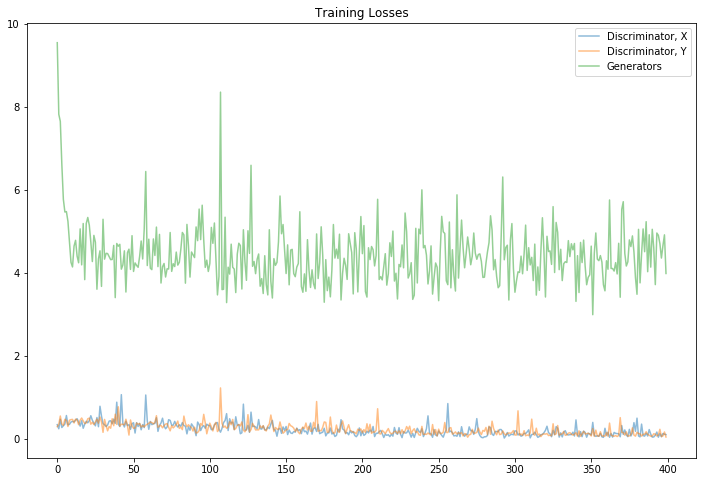

In [46]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [47]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    x2y=0
    y2x=0
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


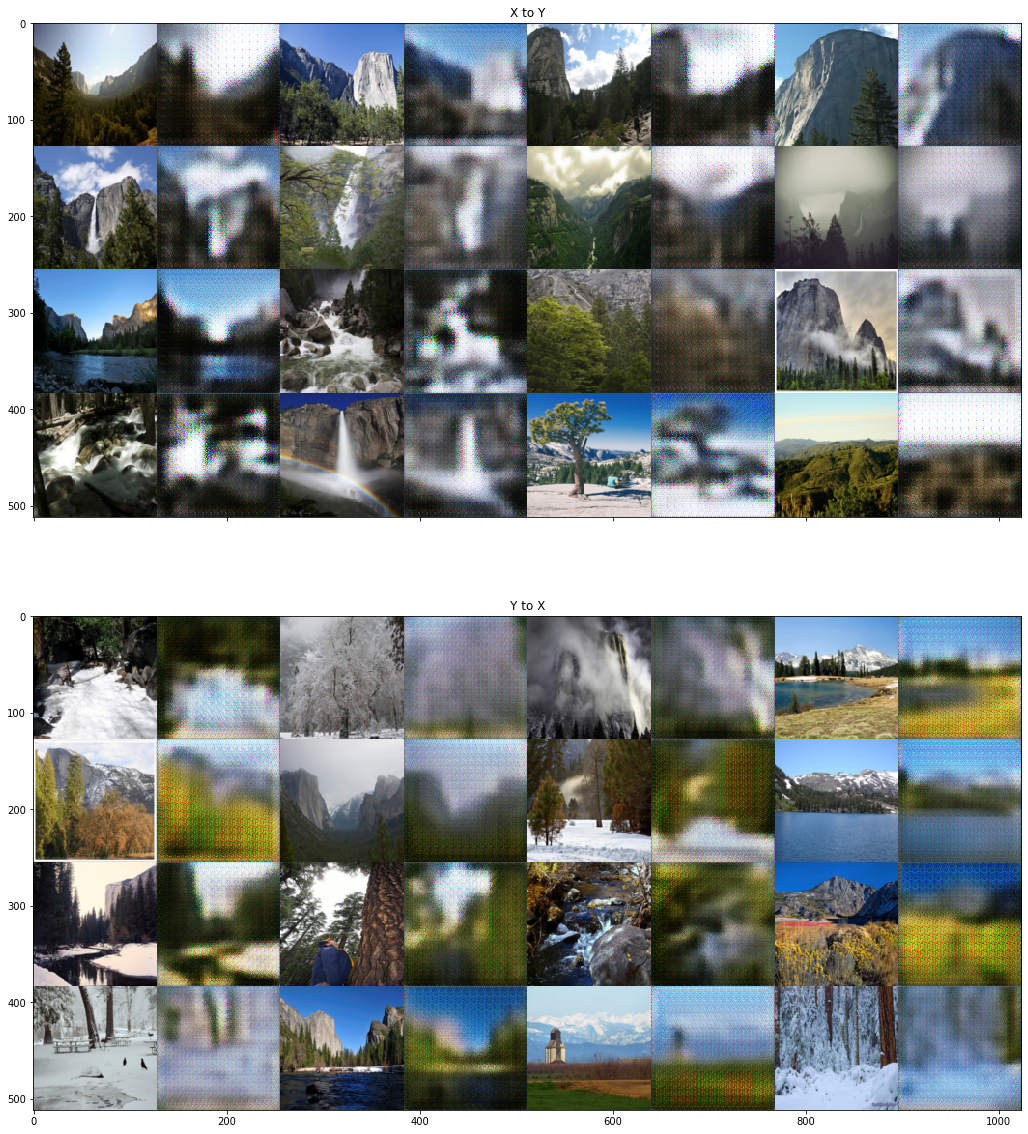

In [48]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

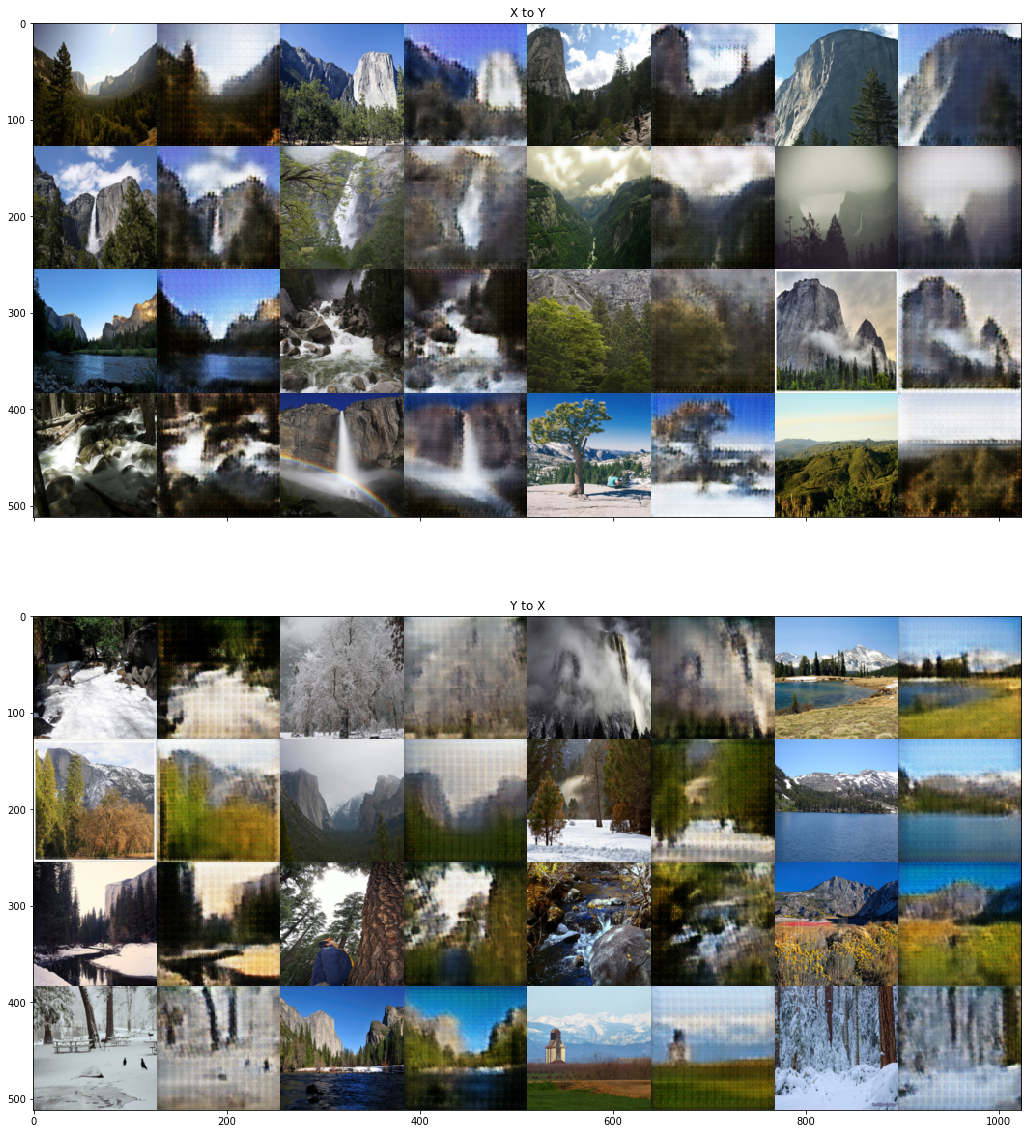

In [49]:
# view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')

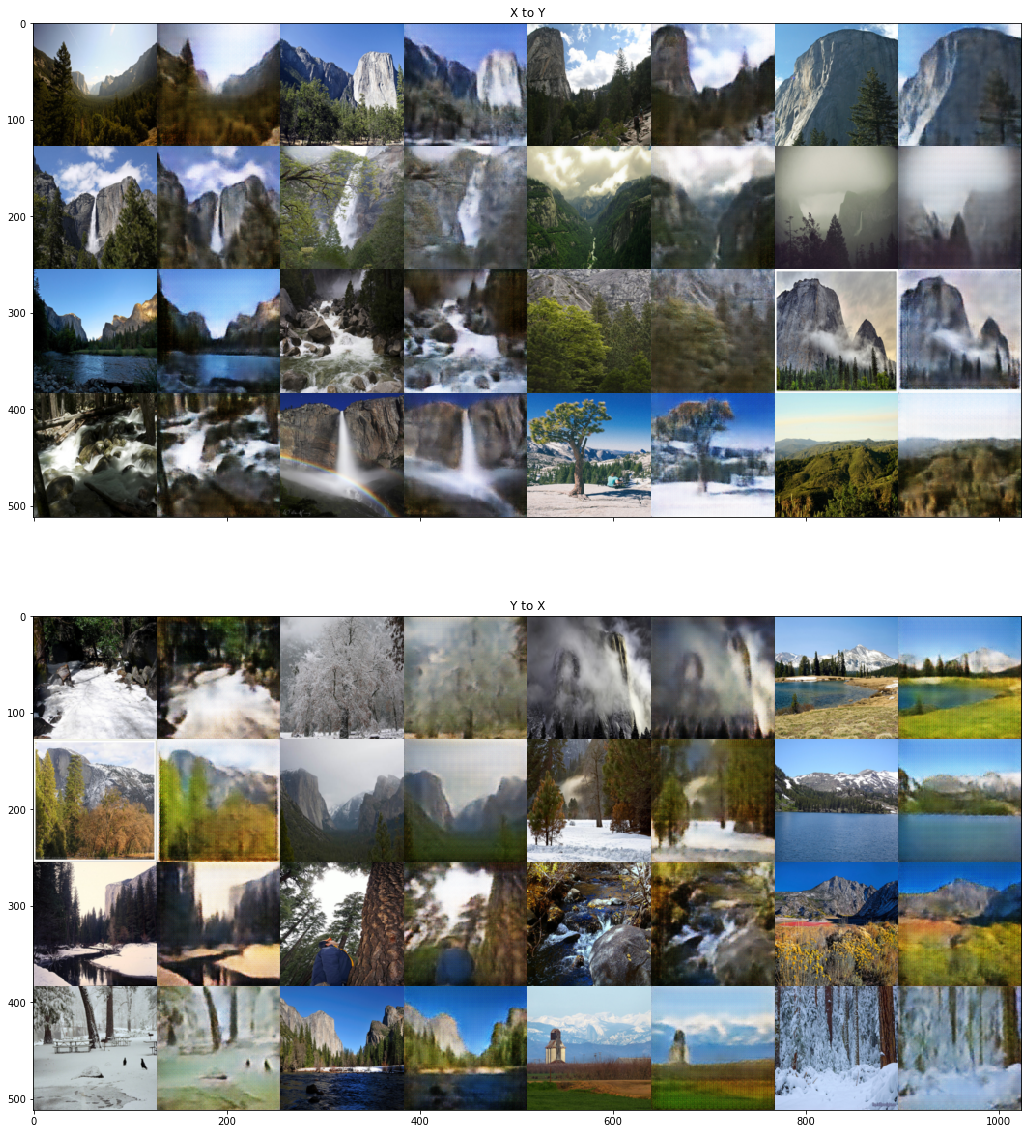

In [50]:
# view samples at iteration 1000
view_samples(4000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.